In [21]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from scipy import ndimage


Assignment 2 Question 1.a

Reading a frame from the video 

In [22]:
vidcap = cv.VideoCapture(r'I:\murali\Assignment2\question1\video.mp4')
check,image = vidcap.read()
count = 0
inc=0
while check:
    check,image = vidcap.read()
    if count%59==0 :
      inc+=1
      if inc==1 or inc==4:
          cv.imwrite(r"I:\murali\Assignment2\question1\frame%d.jpg" % inc, image)         
    count += 1

Original Image

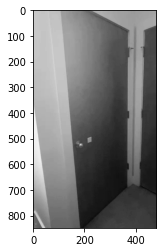

In [23]:

img = cv.imread(r'I:\murali\Assignment2\question1\frame1.jpg',0)
#original image in gray scale
plt.imshow(img,cmap='gray')

HarrisCorner Detection

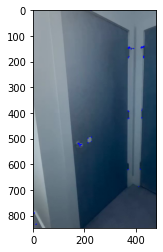

In [24]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
filename = r'I:\murali\Assignment2\question1\frame1.jpg'
img = cv.imread(filename)
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
gray = np.float32(gray)
dst = cv.cornerHarris(gray,2,3,0.07)
dst = cv.dilate(dst,None)
img[dst>0.01*dst.max()]=[0,0,255]
cv.imwrite(r'I:\murali\Assignment2\question1\cornersPicture.jpg',img)
plt.imshow(img,cmap='gray')


Canny Edge Detection


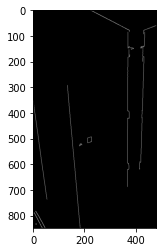

In [25]:

img = cv.imread(r'I:\murali\Assignment2\question1\frame1.jpg',0)
edges = cv.Canny(img,100,200)
plt.imshow(edges,cmap='gray')

Canny Edge Detection without using inbuilt functions
        
    The Canny edge detection algorithm is composed of 5 steps:

        Noise reduction;
        Gradient calculation;
        Non-maximum suppression;
        Double threshold;
        Edge Tracking by Hysteresis.    

In [26]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

In [27]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

In [28]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [29]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio
    lowThreshold = highThreshold * lowThresholdRatio
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

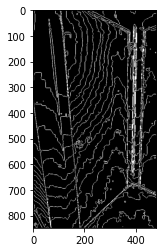

In [30]:
import matplotlib.pyplot as plt
import cv2 as cv
frame = cv.imread(r'I:\murali\Assignment2\question1\frame1.jpg',0)
g=gaussian_kernel(5,5)
weak_th = None 
strong_th = None    
img= cv.filter2D(src=frame, kernel=g, ddepth=19)
mag,ang=sobel_filters(img)
mag_max = np.max(mag)
c=non_max_suppression(mag,ang)
a,b,d=threshold(c)       
plt.imshow(a,cmap='gray')

Assignment2 Question 1.b
    
    homography matrix 


In [31]:
MIN_MATCH_COUNT = 10
img1 = cv.imread(r'I:\murali\Assignment2\question1\frame1.jpg',0)  
img2 = cv.imread(r'I:\murali\Assignment2\question1\frame2.jpg',0)
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [32]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img2 = cv.polylines(img2,[np.int32(dst)],True,255,3, cv.LINE_AA)
    print("Homography Matrix")
    print(M)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

Homography Matrix
[[ 1.69925686e+00  1.18345565e-01 -5.10025542e+02]
 [ 4.94741298e-01  1.55222834e+00 -1.84705632e+02]
 [ 1.38664737e-03  1.08813230e-05  1.00000000e+00]]


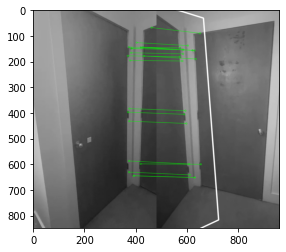

In [33]:
draw_params = dict(matchColor = (0,255,0), 
                   singlePointColor = None,
                   matchesMask = matchesMask, 
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
cv.imwrite(r'I:\murali\Assignment2\question1\MathingPointsBetweenFrame1andFrame2.jpg',img3)
plt.imshow(img3, 'gray')
#plt.show()